In [15]:
import os, sys
sys.path.append("../src")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch
lt.monkey_patch()
from safetensors.torch import load_file

from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.wan_generate_video import merge_lora_weights
from musubi_tuner.utils.preproc_utils import preproc_image, preproc_mask, postproc_imgs
from musubi_tuner.utils.preproc_utils import get_text_preproc, prepare_control_inputs_for_entity, get_all_kwargs_from_opens2v_metapath
from musubi_tuner.utils.preproc_utils import getres, get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map
from musubi_tuner.utils.viz_utils import printable_metadata, return_total_visualization
from musubi_tuner.utils.bbox_utils import get_mask_from_bboxes, draw_bboxes, draw_bboxes_images, auto_scale_layout_data, get_bbox_from_mask
from musubi_tuner.utils.keypalign_utils import search_facebbox_for_layout

sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset

device = torch.device('cuda')

In [ ]:
# main_path = Path("/projects/bffz/ykwon4/ComfyUI/models")
main_path = Path("/lustre/fs1/home/yo564250/workspace/ComfyUI/models")
dit_path = "diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "text_encoders/clip_l.safetensors"
lora_path = '../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_4-step00006000.safetensors'

model = load_packed_model(device, main_path / dit_path, 'sageattn', device, has_image_proj=False)
model.to(device)
model.eval().requires_grad_(False)

if lora_path is not None:
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], lora_multiplier = [1.0], 
            include_patterns=None, exclude_patterns=None, lycoris=None, save_merged_model=False
        ), 
    device, None)

vae = load_vae(str(main_path / vae_path), 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=str(main_path / text_encoder1_path)), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=str(main_path / text_encoder2_path)))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_4-step00006000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:cre

Entity 1
	Control Image Path: ../../docs/fg_sample.jpg
	Control Image Size: (192, 192)
	Attn BBox: [0.640, 0.100, 1.000, 0.910]
	Face BBox: [0.640, 0.100, 1.000, 0.460]


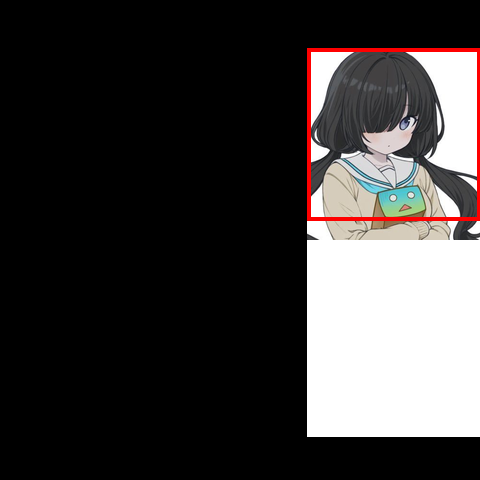

In [3]:
prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
height, width = 480, 480
entity_bboxes = [[ 0.6, 0.1, 1.0, 1.0 ]]
control_image_paths = [["../../docs/fg_sample.jpg"]]

layout_dict = {i : {'bbox' : v, 'body': []} for i,v in enumerate(entity_bboxes)}
characters_shot = {i : {'images' : v} for i,v in enumerate(control_image_paths)}
auto_scaled_layout, metadata = auto_scale_layout_data(layout_dict)
debug_dict = search_facebbox_for_layout(
    auto_scaled_layout, characters_shot, (width, height), use_face_detect=True,)
for k,v in debug_dict.items():
    print(f"Entity {k+1}")
    print(f"\tControl Image Path: {v['control_image_path']}")
    print(f"\tControl Image Size: {v['control_image_size']}")
    print("\tAttn BBox: [" + ', '.join([f"{b:.3f}" for b in v['entity_bbox']]) + "]")
    print("\tFace BBox: [" + ', '.join([f"{b:.3f}" for b in v['face_bbox']]) + "]")

max_characters=1
if len(debug_dict) == 0:
    control_image_paths = []
    control_image_sizes = []
    entity_bboxes = []
    face_bboxes = []
else:
    control_image_paths = [debug_dict[i]['control_image_path'] for i in range(max_characters)]
    control_image_sizes = [debug_dict[i]['control_image_size'] for i in range(max_characters)]
    entity_bboxes = [debug_dict[i]['entity_bbox'] for i in range(max_characters)]
    face_bboxes = [debug_dict[i]['face_bbox'] for i in range(max_characters)]

entitymask_nps = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 1)

debug_mask = Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")
debug_mask = draw_bboxes_images(debug_mask, face_bboxes, control_image_paths, cimg_sizes=control_image_sizes)
debug_mask = draw_bboxes(debug_mask, face_bboxes, width=4)
debug_mask

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 1044, 3072] bf16 n=3207168 (6.1Mb) x∈[-15.625, 18.000] μ=-0.016 σ=0.715 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 21, 3072] bf16 n=64512 (0.1Mb) x∈[-4.576e+03, 484.000] μ=-0.031 σ=20.500 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.875, 19.000] μ=-0.105 σ=0.930 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 1065, 1065] bf16 n=1134225 (2.2Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 1044, 256] n=267264 (1.0Mb) x∈[-1.000, 1.000] μ=0.369 σ=0.603 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 900, 256] n=230400 (0.9Mb) x∈[-1.000, 1.000] μ=0.370 σ=0.602 cuda:0, tensor[1, 144, 256] n=36864 (0.1Mb) x∈[-1.000, 1.000] μ=0.362 σ=0.607 cuda:0], 'clean_latents': [(0, 144)], 'noise': [(144, 1044)], 'text_embeddings': [(1044, 1065)]})
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tun

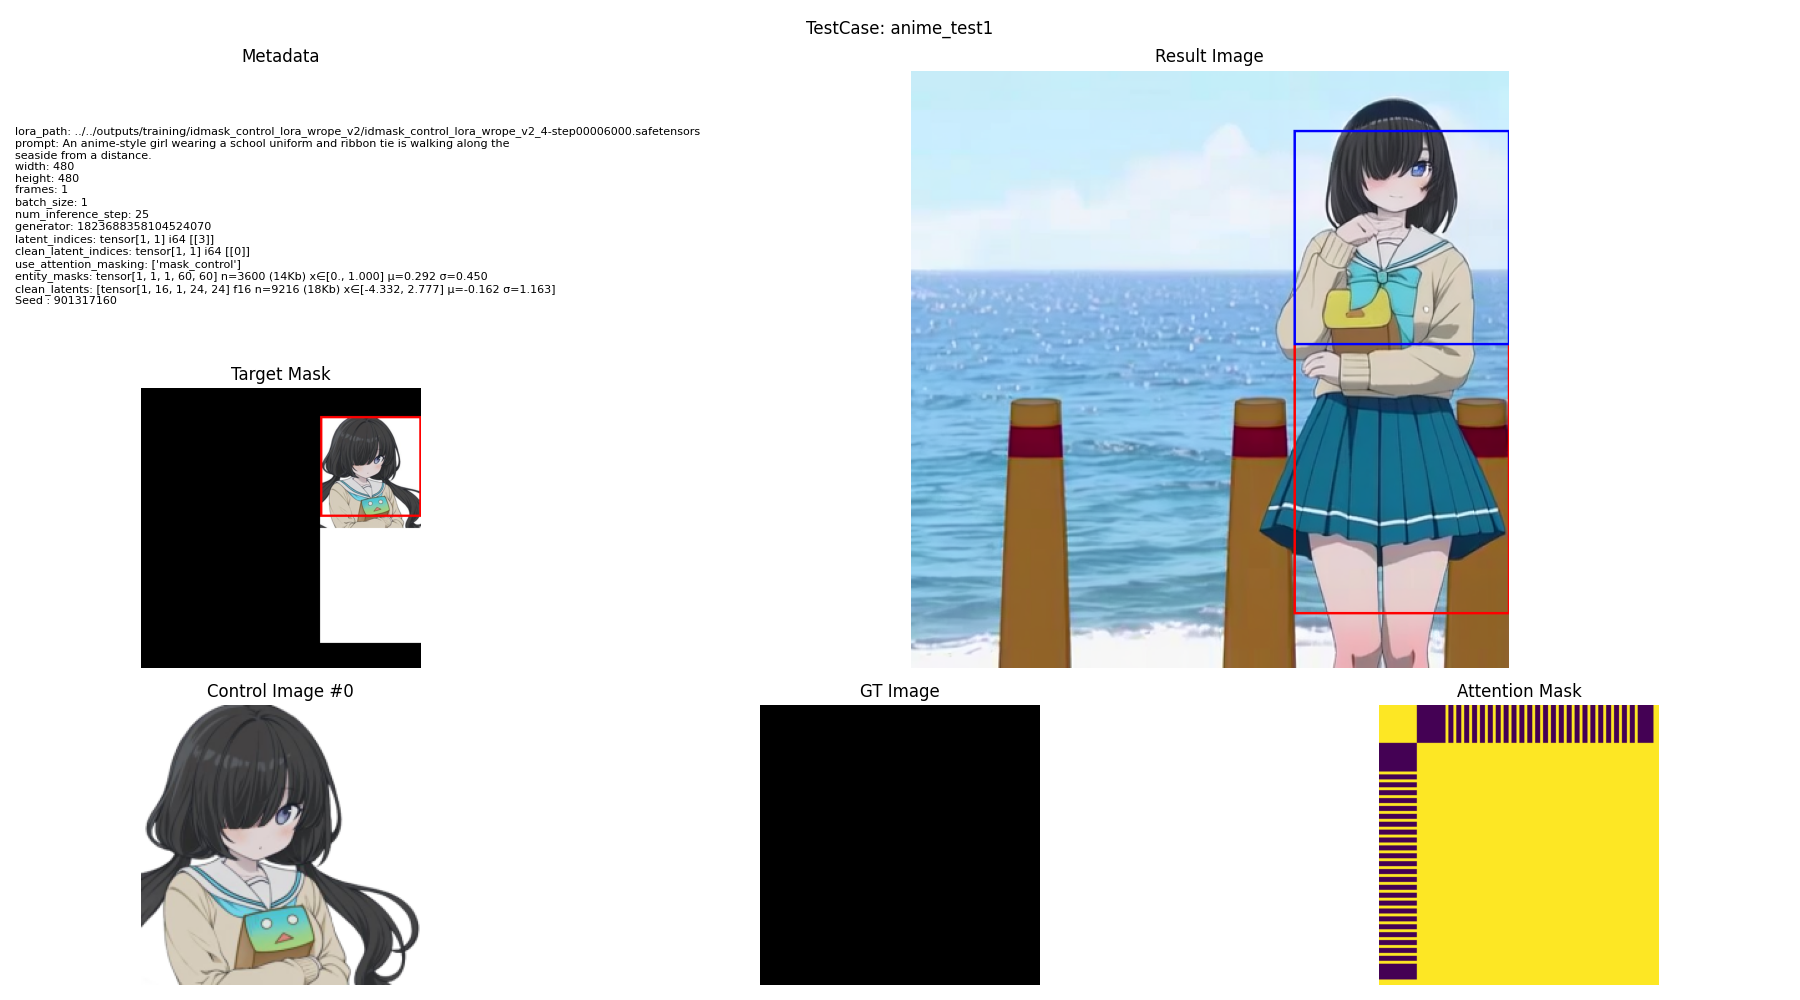

In [4]:
text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, width, height, vae,
    control_image_sizes, face_entity_bboxes=face_bboxes,
    control_indices=[0], latent_indices=[3], 
    adjust_custom_wh=False, mode="provided_face_bbox",
    use_rembg=True)

seed = np.random.randint(2**31)
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'real_guidance_scale': 1.0, 'distilled_guidance_scale': 10.0, 'guidance_rescale': 0.0, 'shift': None,
    'num_inference_step': 25, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': True, 'cache_layers': [], 'use_attention_masking': ['mask_control'],
    'entity_masks': entity_masks,
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])
result_img = draw_bboxes(result_img, entity_bboxes)
result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes'].numpy()[0], color=(0,0,255))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80, seed=seed)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization('anime_test1', meta_str, np.asarray(result_img), 
                                        attn_mask, control_nps[0], np.asarray(debug_mask), 
                                        np.zeros((height, width, 3), dtype=np.uint8))
result_img

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 4770, 3072] bf16 n=14653440 (28Mb) x∈[-17.500, 20.125] μ=-0.011 σ=0.930 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 192, 3072] bf16 n=589824 (1.1Mb) x∈[-3.600e+03, 494.000] μ=0.053 σ=11.750 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.375, 19.125] μ=-0.103 σ=0.922 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 4962, 4962] bf16 n=24621444 (47Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 4770, 256] n=1221120 (4.7Mb) x∈[-1.000, 1.000] μ=0.308 σ=0.637 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 3600, 256] n=921600 (3.5Mb) x∈[-1.000, 1.000] μ=0.310 σ=0.635 cuda:0, tensor[1, 1170, 256] n=299520 (1.1Mb) x∈[-1.000, 1.000] μ=0.301 σ=0.640 cuda:0], 'clean_latents': [(0, 1170)], 'noise': [(1170, 4770)], 'text_embeddings': [(4770, 4962)]})


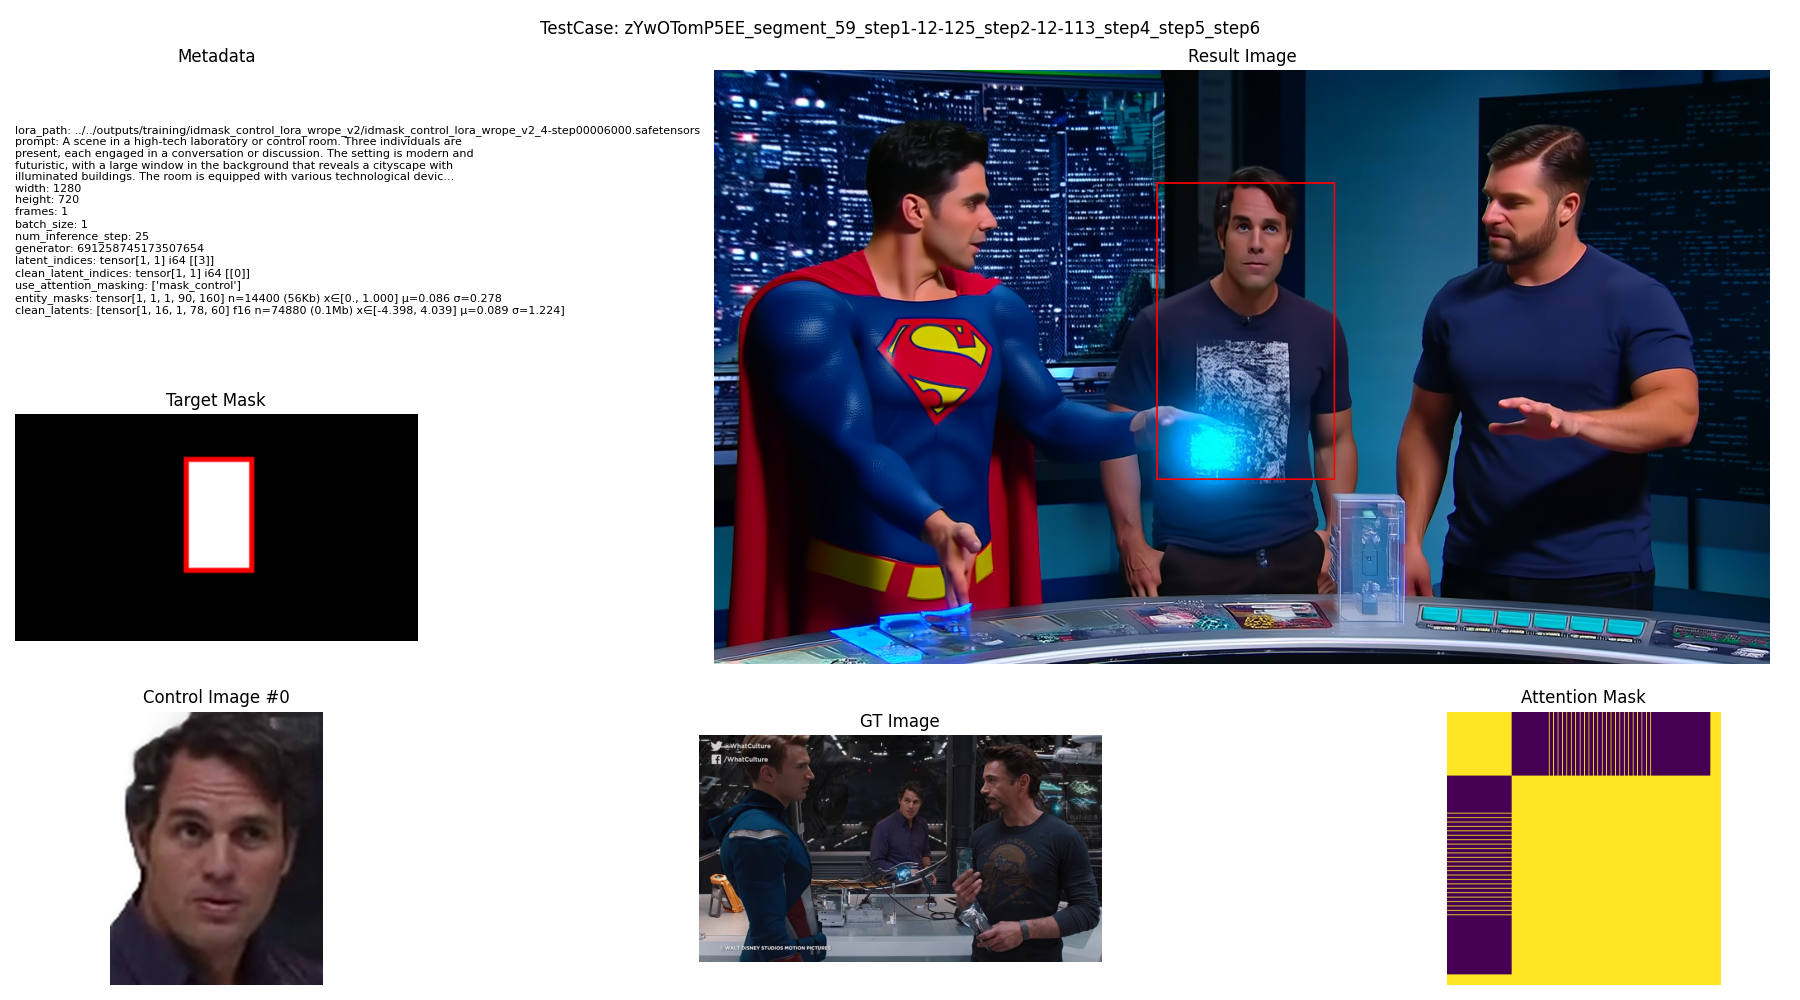

In [5]:
# dset_path = Path("/projects/bffz/ykwon4/OpenS2V-Nexus/")
dset_path = Path("/lustre/fs1/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2"
# dset_name = "test3_part2"
# name = "RH9DTExtz1s_segment_55_step1-0-73_step2-0-73_step4_step5_step6"
name = "zYwOTomP5EE_segment_59_step1-12-125_step2-12-113_step4_step5_step6"
# name = "qo_3QHD9gYQ_segment_4_step1-0-173_step2-0-173_step4_step5_step6"
el_path = dset_path / f"{dset_name}/{name}"

width, height = 1280, 720
seed = -1
total_kwargs, total_nps = get_all_kwargs_from_opens2v_metapath(
    el_path, steps=25, seed=seed, width=width, height=height, 
)
text_kwargs = get_text_preproc(
    total_kwargs['prompt'], text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    total_kwargs['control_image_paths'], total_nps['bboxes'], width, height, vae,
    control_image_sizes=[(480,None)], face_entity_bboxes=None,
    control_indices=[0], latent_indices=[3], 
    adjust_custom_wh=False, mode="provided_size_mid_x",
    use_rembg=True)

attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)
result_img = draw_bboxes(Image.fromarray(postproc_imgs(results, vae)[0]), total_nps['bboxes'])

mask = Image.fromarray(total_nps['entitymask_nps'][0]).convert("RGB")
mask = np.asarray(draw_bboxes(mask, control_kwargs['clean_latent_bboxes'][0]))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(
    name, meta_str, np.asarray(result_img), 
    attn_mask, control_nps[0], mask, total_nps['gt_np'])
result_img

In [6]:
def get_control_kwargs_full(panel_layout, characters_shot, width, height, 
        crop_face_detect=True, use_face_detect=True,
        c_width_given=None, scale_c=1.2, use_safety=True,
        bbox_mode="full_width_relative_height",
        max_characters=2, control_indices=[0], latent_indices=[3], 
        use_rembg=True):
    auto_scaled_layout, metadata = auto_scale_layout_data(panel_layout)

    debug_dict = search_facebbox_for_layout(
        auto_scaled_layout, characters_shot, (width, height), 
        crop_face_detect=crop_face_detect, use_face_detect=use_face_detect,
        c_width_given=c_width_given, scale_c=scale_c, use_safety=use_safety,
        bbox_mode=bbox_mode)

    print_res = ""
    for k,v in debug_dict.items():
        print_res += f"Entity {k+1} (Use Crop: {crop_face_detect})\n"
        print_res += f"\tControl Image Path: {v['control_image_path']}\n"
        print_res += f"\tControl Image Size: {v['control_image_size']}\n"
        print_res += "\tAttn BBox: [" + ', '.join([f"{b:.3f}" for b in v['entity_bbox']]) + "]\n"
        print_res += "\tFace BBox: [" + ', '.join([f"{b:.3f}" for b in v['face_bbox']]) + "]\n"

    n_chara = min(len(debug_dict), len(characters_shot), max_characters)
    if len(debug_dict) == 0:
        control_images = []
        control_image_sizes = []
        entity_bboxes = []
        face_bboxes = []
        entity_masks = None
        debug_mask = Image.new("RGB", (width, height), (0,0,0))
    else:
        control_images = [debug_dict[i]['control_image'] for i in range(n_chara)]
        control_image_sizes = [debug_dict[i]['control_image_size'] for i in range(n_chara)]
        entity_bboxes = [debug_dict[i]['entity_bbox'] for i in range(n_chara)]
        face_bboxes = [debug_dict[i]['face_bbox'] for i in range(n_chara)]
        entitymask_nps = [get_mask_from_bboxes([entity_bbox], width, height) for entity_bbox in entity_bboxes]
        entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 2)

        debug_mask = Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")
        debug_mask = draw_bboxes_images(debug_mask, face_bboxes, control_images, cimg_sizes=control_image_sizes)
        debug_mask = draw_bboxes(debug_mask, face_bboxes, width=4)

    control_kwargs, control_nps = prepare_control_inputs_for_entity(
        control_images, entity_bboxes, width, height, vae,
        control_image_sizes,
        face_entity_bboxes=face_bboxes,
        control_indices=control_indices, latent_indices=latent_indices,
        adjust_custom_wh=False, 
        mode="provided_face_bbox",  # mode="provided_size_mid_x",
        use_rembg=use_rembg)
    if len(control_nps) > 0:
        control_nps = np.concatenate([
            np.asarray(Image.fromarray(x).resize((256,256))) for x in control_nps], 
        axis=1)
    else:
        control_nps = np.zeros((256,256,3), dtype=np.uint8)
    return control_kwargs, entity_masks, debug_mask, control_nps, print_res

In [ ]:
vistory_dataset_path = Path('/groups/chenchen/patrick/ViStoryBench/dataset/ViStory')
vistory_dataset = StoryDataset(vistory_dataset_path)
main_layout_path = Path(f"/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053/")
currtime = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")
main_output_path = Path(f"/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/vistory_test/base/en/{currtime}")
main_output_path.mkdir(parents=True, exist_ok=True)

max_scene_sentences = 3
max_characters = 2
scale_c = 1.2

story_num = '04' #01~80 [f"{x:02d}" for x in range(1,81)]
# shot_nums = [x['index'] for x in vistory_dataset.load_shots('04')]
shot_num = 2

story_shot, characters_shot = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = story_shot['type'] + ". " + ", ".join(story_shot['scene'].split(", ")[:max_scene_sentences]) + ". " + story_shot['script']
# print(f"Prompt: {prompt}")
text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

layouts = [
    (x.stem, list(map(int, x.stem.split("-pages_")[-1].split("_")))) 
    for x in  list(main_layout_path.glob(f"story_{story_num}*"))]
layout_name = [(x[0], x[1][0]) for x in layouts if shot_num in range(x[1][0], x[1][1]+1)][0]
author_output_dir = main_layout_path / layout_name[0]
layout = parse_bodylayout(author_output_dir / "pose_layout.json")
layout_img = Image.open(author_output_dir / "final_layout.png")

panel_bbox, panel_layout = layout[f'[PANEL-{shot_num-layout_name[1]+1}]']
width, height = getres(panel_bbox[2]-panel_bbox[0], panel_bbox[3]-panel_bbox[1], 
    target_area=1280*720, max_aspect_ratio=2.0)
# print(f"Size: ({width}, {height})")

control_kwargs, entity_masks, debug_mask, control_nps, print_res = get_control_kwargs_full(
    panel_layout, characters_shot, width, height, 
    crop_face_detect=True, use_face_detect=True, c_width_given=None, scale_c=scale_c,
    max_characters=max_characters, control_indices=[0], latent_indices=[3], 
    use_rembg=True
)
# print(print_res)

seed = np.random.randint(2**31)
# seed = 12961996
# seed = 578713454
# seed = 893873836
# seed = 449587042, 622444233
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'num_inference_step': 25, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': False, 'cache_layers': [], 
    'use_attention_masking': ['no_cross_control_latents', 'mask_control'],
    'entity_masks': entity_masks,
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])

meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80, seed=seed)
meta_str = meta_str + "\n\n" + print_res
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)

debug_img = return_total_visualization('anime_test1', meta_str, np.asarray(result_img), 
                                        attn_mask, np.asarray(control_nps), np.asarray(debug_mask), 
                                        np.zeros((height, width, 3), dtype=np.uint8))

output_path = main_output_path / f"{story_num}"
output_path.mkdir(parents=True, exist_ok=True)
result_img.save(output_path / f"{shot_num}_0.png")
debug_img.save(output_path / f"{shot_num}_debug.png")
debug_mask.save(output_path / f"{shot_num}_mask.png")
(output_path / f'{shot_num}_meta.txt').write_text(meta_str, encoding='cp949')

DWPose: Bbox 9.46ms
DWPose: Pose 12.18ms on 1 people

DWPose: Bbox 9.25ms
DWPose: Pose 11.08ms on 1 people



  0%|          | 0/25 [00:00<?, ?it/s]

1363

Shot 1
Prompt: Chinese Ancient Wuxia. Daytime, snow-covered wilderness, a cold and lonely atmosphere. Li Xunhuan sits inside the carriage, slightly bowing his head, holding a wine flask in his hand, his expression melancholic. The wrinkles around his eyes appear deeper in the dim light. He coughs intermittently, his body trembling slightly.
Size: (896, 1024)
DWPose: Bbox 8423.48ms
DWPose: Pose 2796.23ms on 1 people

Entity 1
	Control Image Path: <PIL.Image.Image image mode=RGB size=512x512 at 0x7F4030F6B820>
	Control Image Size: (592, 592)
	Attn BBox: [0.111, 0.268, 0.706, 0.775]
	Face BBox: [0.196, 0.153, 0.654, 0.554]


  0%|          | 0/25 [00:00<?, ?it/s]

Shot 2
Prompt: Chinese Ancient Wuxia. Daytime, snow-covered wilderness, a cold and lonely atmosphere. Li Xunhuan focuses intently on carving the figure, his eyes revealing deep longing. The small knife in his hand glides gently over the wood block, wood shavings falling. His expression is tender yet sorrowful.
Size: (1200, 768)
DWPose: Bbox 10.10ms
DWPose: Pose 11.59ms on 1 people

Entity 1
	Control Image Path: <PIL.Image.Image image mode=RGB size=512x512 at 0x7F402856A0E0>
	Control Image Size: (592, 592)
	Attn BBox: [0.016, 0.224, 0.555, 0.759]
	Face BBox: [0.198, 0.115, 0.539, 0.648]


  0%|          | 0/25 [00:00<?, ?it/s]

Shot 3
Prompt: Chinese Ancient Wuxia. Daytime, snow-covered wilderness, a desolate and silent atmosphere. The footprints in the snow are clearly visible, winding forward toward the distant mountains. The surroundings are silent, with only the howling wind.
Size: (1360, 672)


  0%|          | 0/25 [00:00<?, ?it/s]

Shot 4
Prompt: Chinese Ancient Wuxia. Daytime, snow-covered wilderness, a cold and lonely atmosphere. Li Xunhuan leans out the carriage window, his expression concerned, extending his hand toward the youth. The youth stands beside the carriage, his gaze resolute and stubborn, shaking his head slightly in refusal, his body shivering slightly in the cold wind.
Size: (1408, 656)
DWPose: Bbox 9.86ms
DWPose: Pose 11.54ms on 1 people

DWPose: Bbox 9.29ms
DWPose: Pose 11.34ms on 1 people

Entity 1
	Control Image Path: <PIL.Image.Image image mode=RGB size=512x512 at 0x7F40303A3E20>
	Control Image Size: (592, 592)
	Attn BBox: [0.676, 0.006, 0.942, 0.992]
	Face BBox: [0.565, 0.000, 0.857, 0.402]
Entity 2
	Control Image Path: <PIL.Image.Image image mode=RGB size=512x512 at 0x7F409801FD60>
	Control Image Size: (592, 592)
	Attn BBox: [0.157, 0.241, 0.644, 0.804]
	Face BBox: [0.357, 0.079, 0.648, 0.704]


  0%|          | 0/25 [00:00<?, ?it/s]

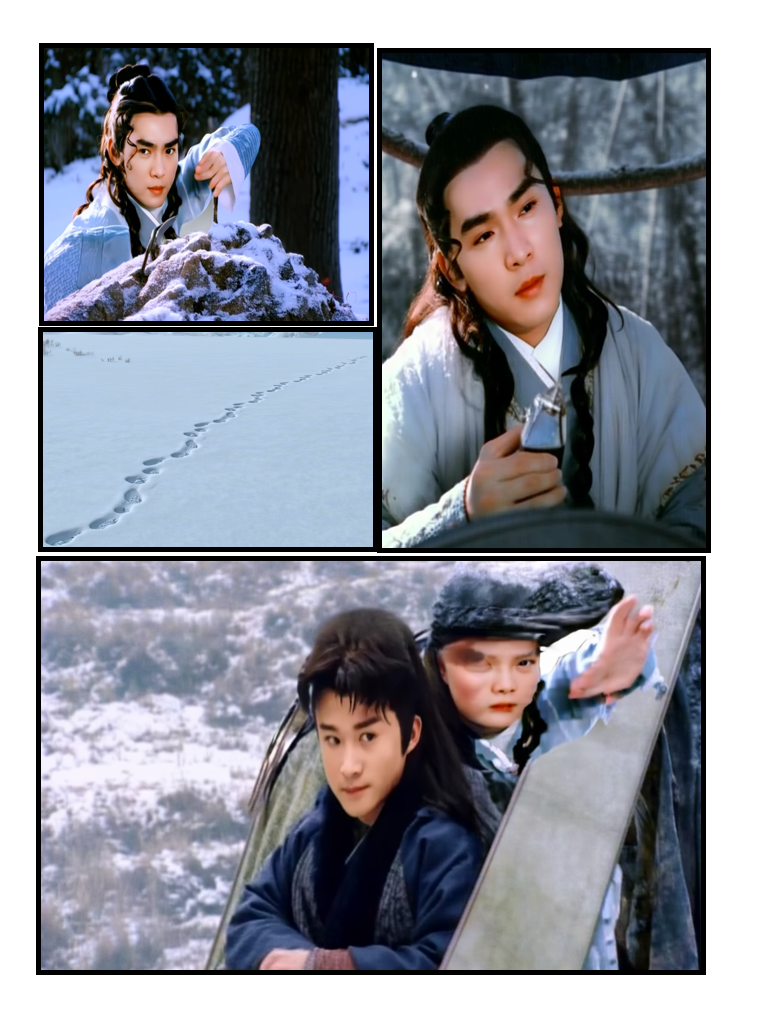

In [5]:
vistory_dataset_path = Path('/groups/chenchen/patrick/ViStoryBench/dataset/ViStory')
layout_dir = Path('/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053/')
story_num = '05'
shot_nums = (1, 4)
max_scene_sentences = 3
max_characters = 2

vistory_dataset = StoryDataset(vistory_dataset_path)

author_output_dir = layout_dir / f"story_{story_num}-pages_{shot_nums[0]}_{shot_nums[1]}"
layout = parse_bodylayout(author_output_dir / "pose_layout.json")

results_dict = {}
for shot_num in range(shot_nums[0], shot_nums[1]+1):
    print(f"Shot {shot_num}")

    story_shot, characters_shot = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
    prompt = story_shot['type'] + ". " + ", ".join(story_shot['scene'].split(", ")[:max_scene_sentences]) + ". " + story_shot['script']
    print(f"Prompt: {prompt}")
    text_kwargs = get_text_preproc(prompt, 
        text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
        entity_prompts=[], device=device)

    panel_bbox, panel_layout = layout[f'[PANEL-{shot_num}]']
    width, height = getres(panel_bbox[2]-panel_bbox[0], panel_bbox[3]-panel_bbox[1], target_area=1280*720)
    print(f"Size: ({width}, {height})")

    control_kwargs, entity_masks, debug_mask, control_nps = get_control_kwargs_full(
        panel_layout, characters_shot, width, height, 
        use_face_detect=True, c_width_given=None, scale_c=1.5,
        max_characters=max_characters, control_indices=[0], latent_indices=[3], 
        use_rembg=True, print_res=True
    )
    seed = np.random.randint(2**31)
    generator = torch.Generator(device="cpu")
    generator.manual_seed(seed)

    total_kwargs = {
        'prompt': prompt, 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
        'num_inference_step': 25, 'generator': generator,
        'device': device, 'dtype': torch.bfloat16,
        'cache_results': False, 'cache_layers': [], 
        'use_attention_masking': ['no_cross_control_latents', 'mask_control'],
        'entity_masks': entity_masks,
    }
    attn_cache.clear()
    results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

    result_img = Image.fromarray(postproc_imgs(results,vae)[0])
    meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, seed=seed, maxlen=80)
    attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)

    debug_img = return_total_visualization('anime_test1', meta_str, np.asarray(result_img), 
                                            attn_mask, np.asarray(control_nps), np.asarray(debug_mask), 
                                            np.zeros((height, width, 3), dtype=np.uint8))
    results_dict[shot_num] = {'Img' : result_img, 'Debug' : debug_img}

final_w, final_h = 768, 1024
final_page = Image.new("RGB", (final_w, final_h), (255, 255, 255))
draw = ImageDraw.Draw(final_page)
for key, value in results_dict.items():
    bbox_loc, body_keyp = layout[f"[PANEL-{key}]"]
    rel_w, rel_h = int((bbox_loc[2]-bbox_loc[0])/1000. * final_w), int((bbox_loc[3]-bbox_loc[1])/1000. * final_h)
    start_x, start_y = int(bbox_loc[0]/1000.*final_w), int(bbox_loc[1]/1000.*final_h)
    resized_img = value['Img'].resize((rel_w, rel_h))
    final_page.paste(resized_img, (start_x, start_y))
    draw.rectangle([start_x, start_y, start_x+rel_w, start_y+rel_h], outline=(0,0,0), width=5)
final_page

672 1360


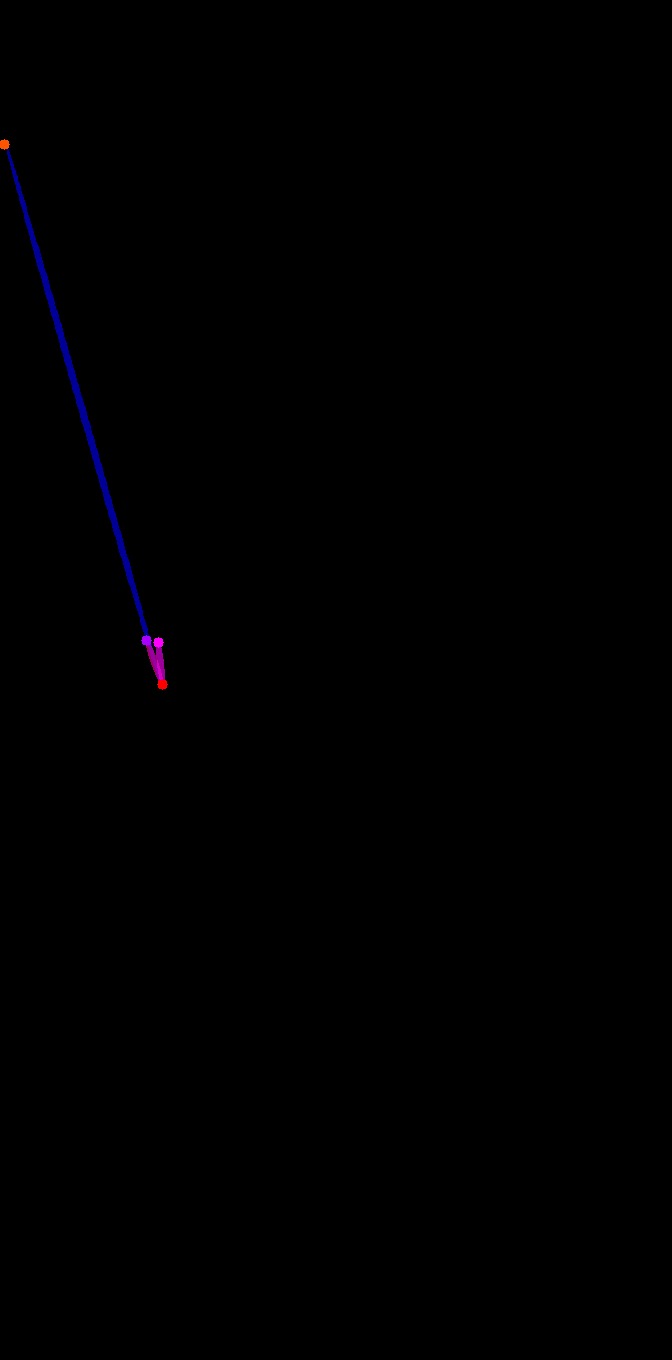

In [8]:
from musubi_tuner.utils.keypalign_utils import *
sys.path.append("/home/yo564250/workspace/whisperer/utils")
from opencv_viz_utils import MMCV_Openpose_Visualizer

layout = parse_bodylayout(author_output_dir / "pose_layout.json")
panel_bbox, panel_layout = layout[f'[PANEL-{shot_num-layout_name[1]+1}]']
width, height = getres(panel_bbox[2]-panel_bbox[0], panel_bbox[3]-panel_bbox[1], 
    target_area=1280*720, max_aspect_ratio=2.0)
# width, height = getres(panel_bbox[2]-panel_bbox[0], panel_bbox[3]-panel_bbox[1], target_area=1280*720)
print(width, height)
auto_scaled_layout, metadata = auto_scale_layout_data(panel_layout)
v = auto_scaled_layout[1]

body_keypoints = np.array(v['body']) * np.array([width, height])[None,:]
full_keypoints = np.zeros((1,18,2))
full_keypoints[0,[0,1,14,15],:] = body_keypoints
full_keypoints_visible = np.zeros((1,18))
full_keypoints_visible[0,[0,1,14,15]] = np.ones((4,))

visualizer = MMCV_Openpose_Visualizer()
skeleton = Image.new("RGB", (width, height), (0,0,0))
skeleton, _ = visualizer(
    np.asarray(skeleton), 
    full_keypoints, 
    full_keypoints_visible, 
    convert_to_openpose=False,
    kpt_thr=0.3)
skeleton = Image.fromarray(skeleton)

skeleton

[512 512]
DWPose: Bbox 10.26ms
DWPose: Pose 26.82ms on 1 people

[[259.94977448 302.8947465 ]]
[[162.6912 684.488 ]]
1.0 [-97.25857448 381.5932535 ]
0.8
(0.0, 0.325, 0.5431547619047619, 0.6264705882352941)


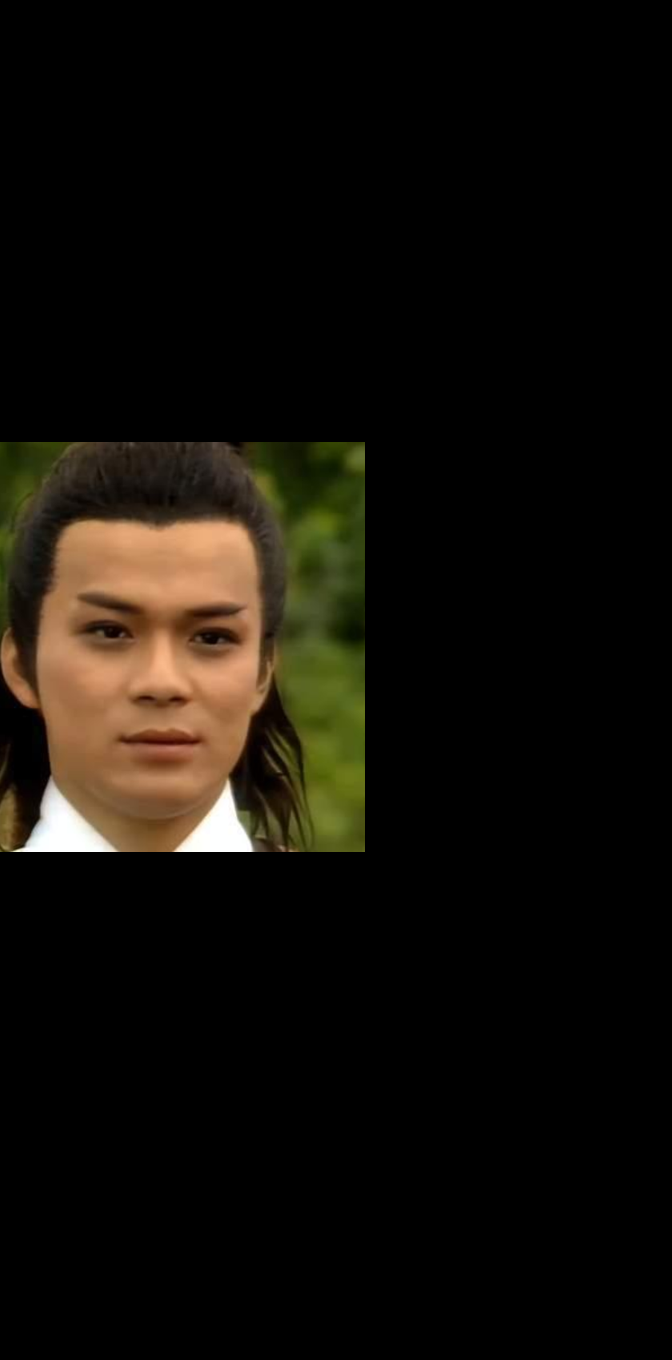

In [12]:
character_name = list(characters_shot.keys())[1]
control_image_path = characters_shot[character_name]['images'][0]        
control_image = Image.open(control_image_path)
control_image = align_face(control_image)
tgt_kps = v['body']

# face_bbox = detect_and_align_source_to_target(
#     control_image, tgt_kps, (width, height), 
#     min_bbox_size=0.04, max_bbox_size=0.2,
#     bbox=v['bbox'])
source_size = np.array(control_image.size)
print(source_size)
out_img, out_json = dwpose_model(control_image, image_and_json=True)
src_kps = out_json['people'][0]['pose_keypoints_2d']
src_kps = np.array(src_kps).reshape(-1,3)[[0,1,14,15]]
valid_src_keyps = src_kps[:,-1].astype(bool) & is_valid_keypoint(src_kps[:,:2])
valid_tgt_keyps = is_valid_keypoint(tgt_kps)
valid_keyps = valid_src_keyps & valid_tgt_keyps
src_kps = src_kps[valid_keyps,:2] 
tgt_kps = np.array(tgt_kps)[valid_keyps,:] * np.array([width, height])  # only use the valid keypoints in source
print(src_kps)
print(tgt_kps)

base_scale, base_translation = solve_scale_translation(src_kps, tgt_kps)
print(base_scale, base_translation)
scale_2 = safety_scale(base_scale, source_size[0], source_size[1], width, height, 
                       min_boundary=0.02, max_boundary=0.2)
print(scale_2)
final_scale, final_translation = rescale_trans(scale_2, None, base_scale, base_translation, src_kps, source_size[0], source_size[1], width, height)
aligned, bbox_result = transform_and_paste(control_image, final_scale, final_translation, (width, height))
print(bbox_result)
aligned
# face_bbox

In [ ]:
dset_path = Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_part2"
# name = 'wfX8k6kqsTM_segment_5_step1-0-251_step2-0-251_step4_step5_step6'
name = 'epRiLMCQtyc_segment_0_step1-0-115_step2-0-115_step4_step5_step6'
text_kwargs = load_file(dset_path / f"{dset_name}_v2_cache/{name}_fp_te.safetensors")
control_kwargs = load_file(dset_path / f"{dset_name}_v2_cache/{name}_1280x0720_fp.safetensors")
# [x.stem.split("_fp_te")[0] for x in dset_path.glob(f"{dset_name}_v2_cache/*_fp_te.safetensors")][:10]

# seed = np.random.randint(2**31)
seed = 84
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()

# N = control_kwargs['clean_latent_bboxes_float32'].shape[0]
N = 2
prompt_embeds = text_kwargs['llama_vec_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16)
prompt_embeds_mask = text_kwargs['llama_attention_mask'].unsqueeze(0).to(device, dtype=torch.bool)
prompt_poolers = text_kwargs['clip_l_pooler_float32'].unsqueeze(0).to(device, dtype=torch.bfloat16)
entity_masks = control_kwargs['target_latent_masks_1x90x160_float16'].unsqueeze(0).to(device, dtype=torch.float32)
clean_latent_bboxes = control_kwargs['clean_latent_bboxes_float32'].unsqueeze(0).to(device, dtype=torch.float32)
gt_latent = control_kwargs['latents_1x90x160_float16'].unsqueeze(0).to(device, dtype=torch.float32)
clean_latents = control_kwargs['latents_clean_1x90x160_float16'].unsqueeze(0).to(device, dtype=torch.float32)
latent_indices = control_kwargs['latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64)
clean_latent_indices = control_kwargs['clean_latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64)

results = sample_hunyuan(
    transformer=model, sampler='unipc', width=1280, height=720, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=25, generator=generator, device=device, dtype=torch.bfloat16, 
    cache_results = True, cache_layers = [], 
    use_attention_masking = ["mask_control"], 
    entity_masks = entity_masks,
    prompt_embeds = prompt_embeds,
    prompt_embeds_mask = prompt_embeds_mask,
    prompt_poolers = prompt_poolers,
    clean_latents = clean_latents,
    clean_latent_indices = clean_latent_indices,
    clean_latent_bbox = clean_latent_bboxes,
    clean_latents_2x = None,
    clean_latent_2x_indices = None,
    clean_latents_4x = None,
    clean_latent_4x_indices = None,
    latent_indices = latent_indices,
)

entity_masks_np = []
bboxes = []
for i in range(entity_masks.shape[2]):
    mask = entity_masks[:,:,i,:,:].permute(0,2,3,1).cpu().numpy().astype(bool)[0,...,0]
    entity_masks_np.append(mask)
    bboxes.append(get_bbox_from_mask(mask))
clean_latent_bboxes_np = [None if sum(x) < 0 else x for x in clean_latent_bboxes.cpu().numpy()[0]]

result_img = Image.fromarray(postproc_imgs(results, vae)[0])
result_img = draw_bboxes(result_img, bboxes)
result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes_float32'].numpy(), color=(0,0,255))

gt_img = postproc_imgs(gt_latent, vae)[0]
control_imgs = postproc_imgs(clean_latents, vae)

debug_mask = Image.fromarray(np.sum(entity_masks_np, axis=0) > 0).convert("RGB")
debug_mask = draw_bboxes_images(debug_mask, clean_latent_bboxes_np, control_imgs)
debug_mask = draw_bboxes(debug_mask, clean_latent_bboxes_np, width=4)

attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(name, "", 
    np.asarray(result_img), attn_mask, control_imgs[0], 
    np.asarray(debug_mask), gt_img
)
result_img

In [ ]:
from musubi_tuner.frame_pack.utils import repeat_to_batch_size

B, C, T, H, W = 1, 16, 1, height//8, width//8

with torch.no_grad():
    processed_clean_latents, clean_latent_rope_freqs = [], []
    latent_n = len(clean_latents) if type(clean_latents) == list else clean_latents.shape[2]
    if type(clean_latents) != list:
        clean_latents = [clean_latents[:,:,[i]] for i in range(latent_n)]

    if clean_latent_indices.shape[1] != latent_n:
        clean_latent_indices = clean_latent_indices.repeat(1, latent_n)
        clean_latent_indices = [clean_latent_indices[:,[i]] for i in range(latent_n)]

    latent_counter = 0
    for i, clean_latent in enumerate(clean_latents):
        clean_latent = clean_latent.to(device, dtype=torch.bfloat16)
        clean_latent = model.clean_x_embedder.proj(clean_latent)
        clean_latent_index = clean_latent_indices[i]

        if clean_latent.shape[0] != B:
            clean_latent = repeat_to_batch_size(clean_latent, B)
        if clean_latent_index.shape[0] != B:
            clean_latent_index = repeat_to_batch_size(clean_latent_index, B)

        _, _, _, clean_H, clean_W = clean_latent.shape

        if clean_latent_bboxes is not None:
            clean_latent_bbox = clean_latent_bboxes[:,i]
            if clean_latent_bbox.shape[0] != B:
                clean_latent_bbox = repeat_to_batch_size(clean_latent_bbox, B)

            clean_latent_rope_freq = []
            for b in range(B):
                cb = [
                    int(clean_latent_bbox[b,0]*W), int(clean_latent_bbox[b,1]*H), 
                    int(clean_latent_bbox[b,2]*W), int(clean_latent_bbox[b,3]*H)
                ]
                cb_rope_freq = model.rope(
                    frame_indices=clean_latent_index[[b]], 
                    height=cb[3], width=cb[2],
                    start_height=cb[1], start_width=cb[0],
                    num_H=clean_H,
                    num_W=clean_W,
                    device=clean_latent.device)
                # logger.info(f"Clean Latent Rope Freq Shape: {cb_rope_freq.shape}")
                clean_latent_rope_freq.append(cb_rope_freq)
            clean_latent_rope_freq = torch.cat(clean_latent_rope_freq, dim=0)
        else:
            clean_latent_rope_freq = model.rope(
                frame_indices=clean_latent_index, 
                height=clean_H, width=clean_W, 
                device=clean_latent.device)

        clean_latent = clean_latent.flatten(2).transpose(1, 2)
        clean_latent_rope_freq = clean_latent_rope_freq.flatten(2).transpose(1, 2)
        
        processed_clean_latents.append(clean_latent)
        clean_latent_rope_freqs.append(clean_latent_rope_freq)
        clean_WH = clean_latent.shape[1]
        latent_counter += clean_WH

    processed_clean_latents = torch.cat(processed_clean_latents, dim=1)
    clean_latent_rope_freqs = torch.cat(clean_latent_rope_freqs, dim=1)


In [ ]:
from collections import defaultdict
latents = torch.randn(
    (1, 16, (1 + 3) // 4, 720 // 8, 1280 // 8), 
    generator=generator
).to(device=device, dtype=torch.bfloat16)
hidden_order_dict = defaultdict(list)

with torch.no_grad():
    # hidden_states, rope_freqs, hidden_order_dict = model.process_input_hidden_states(
    #     hidden_states,
    #     hidden_order_dict,
    #     **control_kwargs
    # )
    hidden_states = model.x_embedder.proj(latents)
    B, C, T, H, W = hidden_states.shape
    latent_indices = control_kwargs['latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.bfloat16)
    hidden_states = hidden_states.flatten(2).transpose(1, 2)
    hidden_WH = hidden_states.shape[1]

    rope_freqs = model.rope(frame_indices=latent_indices, 
                            height=H, width=W, device=hidden_states.device)
    rope_freqs = rope_freqs.flatten(2).transpose(1, 2)
print(rope_freqs)

#     processed_clean_latents, clean_latent_rope_freqs = [], []
#     latent_counter = 0
#     for i, (clean_latent, clean_latent_index) in enumerate(zip(control_kwargs['clean_latents'], control_kwargs['clean_latent_indices'])):
#         clean_latent = model.clean_x_embedder.proj(clean_latent.to(hidden_states))
#         print(clean_latent)
#         _, _, _, clean_H, clean_W = clean_latent.shape
#         clean_latent_bbox = control_kwargs['clean_latent_bboxes'][:,i]
#         print(clean_latent_bbox)

#         clean_latent_rope_freq = []
#         for b in range(B):
#             cb = [
#                 int(clean_latent_bbox[b,0]*W), int(clean_latent_bbox[b,1]*H), 
#                 int(clean_latent_bbox[b,2]*W), int(clean_latent_bbox[b,3]*H)
#             ]
#             print(cb)
#             cb_rope_freq = model.rope(
#                 frame_indices=clean_latent_index[[b]], 
#                 height=cb[3], width=cb[2],
#                 start_height=cb[1], start_width=cb[0],
#                 step_H=(cb[3] - cb[1]) / clean_H,
#                 step_W=(cb[2] - cb[0]) / clean_W,
#                 device=clean_latent.device)
#             print(cb_rope_freq)
#             # logger.info(f"Clean Latent Rope Freq Shape: {cb_rope_freq.shape}")
#             clean_latent_rope_freq.append(cb_rope_freq)
#         clean_latent_rope_freq = torch.cat(clean_latent_rope_freq, dim=0)

#         clean_latent = clean_latent.flatten(2).transpose(1, 2)
#         clean_latent_rope_freq = clean_latent_rope_freq.flatten(2).transpose(1, 2)
#         hidden_order_dict['rope_freqs'].append(clean_latent_rope_freq)
        
#         processed_clean_latents.append(clean_latent)
#         clean_latent_rope_freqs.append(clean_latent_rope_freq)
#         clean_WH = clean_latent.shape[1]
#         hidden_order_dict['clean_latents'].append((latent_counter, latent_counter+clean_WH))
#         latent_counter += clean_WH

#     processed_clean_latents = torch.cat(processed_clean_latents, dim=1)
#     clean_latent_rope_freqs = torch.cat(clean_latent_rope_freqs, dim=1)

#     hidden_states = torch.cat([processed_clean_latents, hidden_states], dim=1)
#     rope_freqs = torch.cat([clean_latent_rope_freqs, rope_freqs], dim=1)
# print(hidden_states)
# print(rope_freqs)


In [ ]:
# print(attn_cache['attn_dict'])

# attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.gray)

# timesteps = sorted(list(attn_cache['transformer_blocks.14'].keys()), reverse=False)
# token_H, token_W = height // 16, width // 16
# token_C = len(control_indices + target_index)

# control_inds = attn_cache['attn_dict']['clean_latents']
# noise_inds = attn_cache['attn_dict']['noise'][-1]
# text_inds = attn_cache['attn_dict']['text_embeddings']

# fig, ax = plt.subplots(len(cache_layers), 3, figsize=(18, 18))
# with torch.inference_mode():
#     for i, block in enumerate(cache_layers):
#         attention_map = []
#         for t in range(0,25,5):
#             attention_prob = attn_cache[block][timesteps[t]]
#             attention_prob = attention_prob[:,:,:noise_inds[1],:].to(device)
#             attention_map.append(attention_prob)
#         attention_map = torch.stack(attention_map, dim=0).mean(dim=0) # B A (CHW) D
#         attention_map = attention_map[:,:,noise_inds[0]:noise_inds[1]].sum(1).squeeze(1).permute(0,2,1)
#         attention_map = rearrange(attention_map, 'B D (H W) -> B D H W', H=token_H, W=token_W)

#         control_attention_data = attention_map[0,control_inds[-1][0]:control_inds[-1][1],:,:].mean(axis=0)
#         control_attention_image = get_pltplot_as_pil(control_attention_data).resize((width,height))

#         entity_attention_data = attention_map[0,text_inds[-1][0]:text_inds[-1][1],:,:].mean(axis=0)
#         entity_attention_image = get_pltplot_as_pil(entity_attention_data).resize((width,height))

#         text_attention_data = attention_map[0,1125:1135,:,:].mean(axis=0)
#         text_attention_image = get_pltplot_as_pil(text_attention_data).resize((width,height))

#         ax[i, 0].set_title(f"Layer {block.split('.')[-1]} - Ref")
#         ax[i, 1].set_title(f"Layer {block.split('.')[-1]} - Entity")
#         ax[i, 2].set_title(f"Layer {block.split('.')[-1]} - Global corr")
#         ax[i, 0].imshow(control_attention_image)
#         ax[i, 1].imshow(entity_attention_image)
#         ax[i, 2].imshow(text_attention_image)
#         ax[i, 0].set_xticks([])
#         ax[i, 1].set_xticks([])
#         ax[i, 2].set_xticks([])
#         ax[i, 0].set_yticks([])
#         ax[i, 1].set_yticks([])
#         ax[i, 2].set_yticks([])

# fig.tight_layout()
# plt.show()

In [ ]:
# from musubi_tuner.hv_train_network import collator_class, load_prompts

# prompts = load_prompts('/groups/chenchen/patrick/OpenS2V-Nexus/datasets/test3_2_sample_prompts.txt')
# masks = [
#     Image.open(x).convert("L") for x in prompts[0]['entity_mask_path']
# ]
# control_images = [
#     Image.open(x).convert("RGB") for x in prompts[0]['control_image_path']
# ]
# w, h = prompts[0]['width'], prompts[0]['height']

# bbox = get_bbox_from_mask(np.array(masks[0]))

# face_bbox = get_facebbox_from_bbox(bbox, 
#     control_images[0].size[0], control_images[0].size[1], w, h, full_width=False)

# draw_bboxes(masks[0].convert("RGB"), [face_bbox])

In [ ]:
# clean_latent_bbox = control_kwargs['clean_latent_bboxes'][:,0]
# clean_H, clean_W = control_kwargs['clean_latents'][0].shape[-2:]
# clean_H, clean_W = clean_H // 2, clean_W // 2

# b = 0
# W, H = width // 16, height // 16
# cb = [
#     int(clean_latent_bbox[b,0]*W), int(clean_latent_bbox[b,1]*H), 
#     int(clean_latent_bbox[b,2]*W), int(clean_latent_bbox[b,3]*H)
# ]

# with torch.no_grad():
#     rope_freqs = model.rope(
#         frame_indices=control_kwargs['latent_indices'], 
#         height=H, width=W, device=device
#     )
#     cb_rope_freq = model.rope(
#         frame_indices=control_kwargs['clean_latent_indices'][0], 
#         height=cb[3], width=cb[2],
#         start_height=cb[1], start_width=cb[0],
#         step_H=(cb[3] - cb[1]) / clean_H,
#         step_W=(cb[2] - cb[0]) / clean_W,
#         device=device)
#     rope_freqs = rope_freqs.flatten(2).transpose(1, 2)
#     cb_rope_freqs = cb_rope_freq.flatten(2).transpose(1, 2)
    
# print(rope_freqs.shape)
# print(cb_rope_freqs.shape)